### Load Data

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import DataLoader, random_split, Subset
from data.load import load_datasets
from sklearn.model_selection import train_test_split

batch_size = 64

#train_data, test_data, validation_data, classes = load_datasets("stanford_dogs")
train_data, test_data, classes, training_label = load_datasets("stanford_dogs")
print(train_data)
#set vali rate
val_size = 0.085

# # calculate size of training set/ vali set
# num_train = len(train_data)
# num_val = int(num_train * val_size)
# num_train -= num_val

# # ramdom_split for new train and val
# train_dataset, val_dataset = random_split(train_data, [num_train, num_val])

# # Load it
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


train_idx, val_idx = train_test_split(list(range(len(training_label))), test_size=val_size, stratify=training_label)

# 根据索引创建训练集和验证集的子集
train_dataset = Subset(train_data, train_idx)
val_dataset = Subset(train_data, val_idx)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # 测试集通


# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
#validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Training set stats:
12000 samples spanning 120 classes (avg 100.000000 per class)
Testing set stats:
8580 samples spanning 120 classes (avg 71.500000 per class)


### Train the model 

In [6]:
from train import train_model
from models import DogBreedPretrainedGoogleNet
from jup_train import train

saved_epoch = None
max_epoch = 1000
learning_rate = 0.01
run_id = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.version.cuda)
print(torch.cuda.is_available())
if device.type == "cuda":
    total_mem = torch.cuda.get_device_properties(0).total_memory
else:
    total_mem = 0 
print("MEM: ", total_mem)
print(device.type)

# Load network and use GPU
model = DogBreedPretrainedGoogleNet()

train_loss, val_loss, val_acc = train(model, train_loader, val_loader, learning_rate, max_epoch, 0, device)

11.8
True
MEM:  25769279488
cuda


c:\Users\soho\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\soho\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Start:
Epoch [1/10]: Training Loss: 4.8466, Validation Loss: 4.7976, Accuracy: 1.08%, time spent: 44.29 sec
Epoch [2/10]: Training Loss: 4.7896, Validation Loss: 4.7894, Accuracy: 1.17%, time spent: 43.50 sec
model saved_models/GoogLeNet_2.pt saved..
Epoch [3/10]: Training Loss: 4.7508, Validation Loss: 4.7950, Accuracy: 0.92%, time spent: 42.40 sec
Epoch [4/10]: Training Loss: 4.6919, Validation Loss: 4.7199, Accuracy: 1.33%, time spent: 44.12 sec
model saved_models/GoogLeNet_4.pt saved..
Epoch [5/10]: Training Loss: 4.6570, Validation Loss: 4.8738, Accuracy: 1.25%, time spent: 43.44 sec
Epoch [6/10]: Training Loss: 4.6035, Validation Loss: 4.8706, Accuracy: 1.67%, time spent: 42.42 sec
model saved_models/GoogLeNet_6.pt saved..
Epoch [7/10]: Training Loss: 4.5474, Validation Loss: 4.5903, Accuracy: 1.67%, time spent: 44.00 sec
Epoch [8/10]: Training Loss: 4.5050, Validation Loss: 4.5825, Accuracy: 2.33%, time spent: 43.74 sec
model saved_models/GoogLeNet_8.pt saved..
Epoch [9

### Save the final model

In [ ]:
torch.save(model.state_dict(), 'final_model_complete.pt')

### Visualization

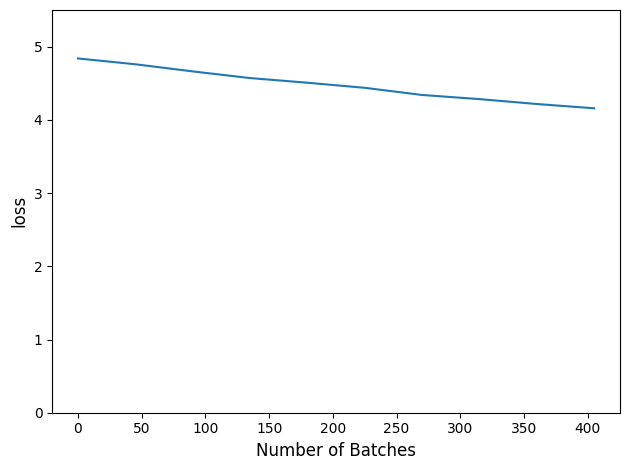

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# analyzeNetwork(net)
    # visualize the loss as the network trained
fig = plt.figure()
plt.plot(45*np.arange(len(train_loss)), train_loss)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.xlabel('Number of Batches', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.ylim(0, 5.5) # consistent scale
plt.tight_layout()
# if plot_path:
#     plt.savefig(os.path.join(plot_path, "Loss_Over_Time"))
#     print("saved")
# else:
plt.show()
plt.clf()

### Test the saved model on a test set

In [ ]:
import numpy as np
# Load the previously saved model.
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
test_loss = torch.zeros(1).to(device)
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))


model.eval()
with torch.no_grad():
    for batch_i, data in enumerate(test_loader):

        # get the input images and their corresponding labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass to get outputs
        outputs = model(inputs)

        # calculate the loss
        loss = loss_fn(outputs, labels.long())

        # update average test loss
        #test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
        test_loss = test_loss + ((torch.ones(1, device=device) / (batch_i + 1)) * (loss.data - test_loss))

        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)

        # compare predictions to true label
        # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

        # calculate test accuracy for *each* object class
        # we get the scalar value of correct items for a class, by calling `correct[i].item()`
        for l, c in zip(labels.data, correct):
            class_correct[l] += c.item()
            class_total[l] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss.cpu().numpy()[0]))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %30s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))



Test Loss: 4.252735

Test Accuracy of                       Chihuaha:  0% ( 0/52)
Test Accuracy of               Japanese Spaniel:  2% ( 2/85)
Test Accuracy of                    Maltese Dog: 17% (26/152)
Test Accuracy of                       Pekinese:  0% ( 0/49)
Test Accuracy of                       Shih-Tzu:  0% ( 0/114)
Test Accuracy of               Blenheim Spaniel: 62% (55/88)
Test Accuracy of                       Papillon:  0% ( 0/96)
Test Accuracy of                    Toy Terrier:  1% ( 1/72)
Test Accuracy of            Rhodesian Ridgeback:  0% ( 0/72)
Test Accuracy of                   Afghan Hound:  0% ( 1/139)
Test Accuracy of                   Basset Hound:  2% ( 2/75)
Test Accuracy of                         Beagle:  0% ( 0/95)
Test Accuracy of                     Bloodhound:  1% ( 1/87)
Test Accuracy of                       Bluetick:  2% ( 2/71)
Test Accuracy of        Black-and-tan Coonhound: 18% (11/59)
Test Accuracy of                   Walker Hound: 13% ( 7/53)


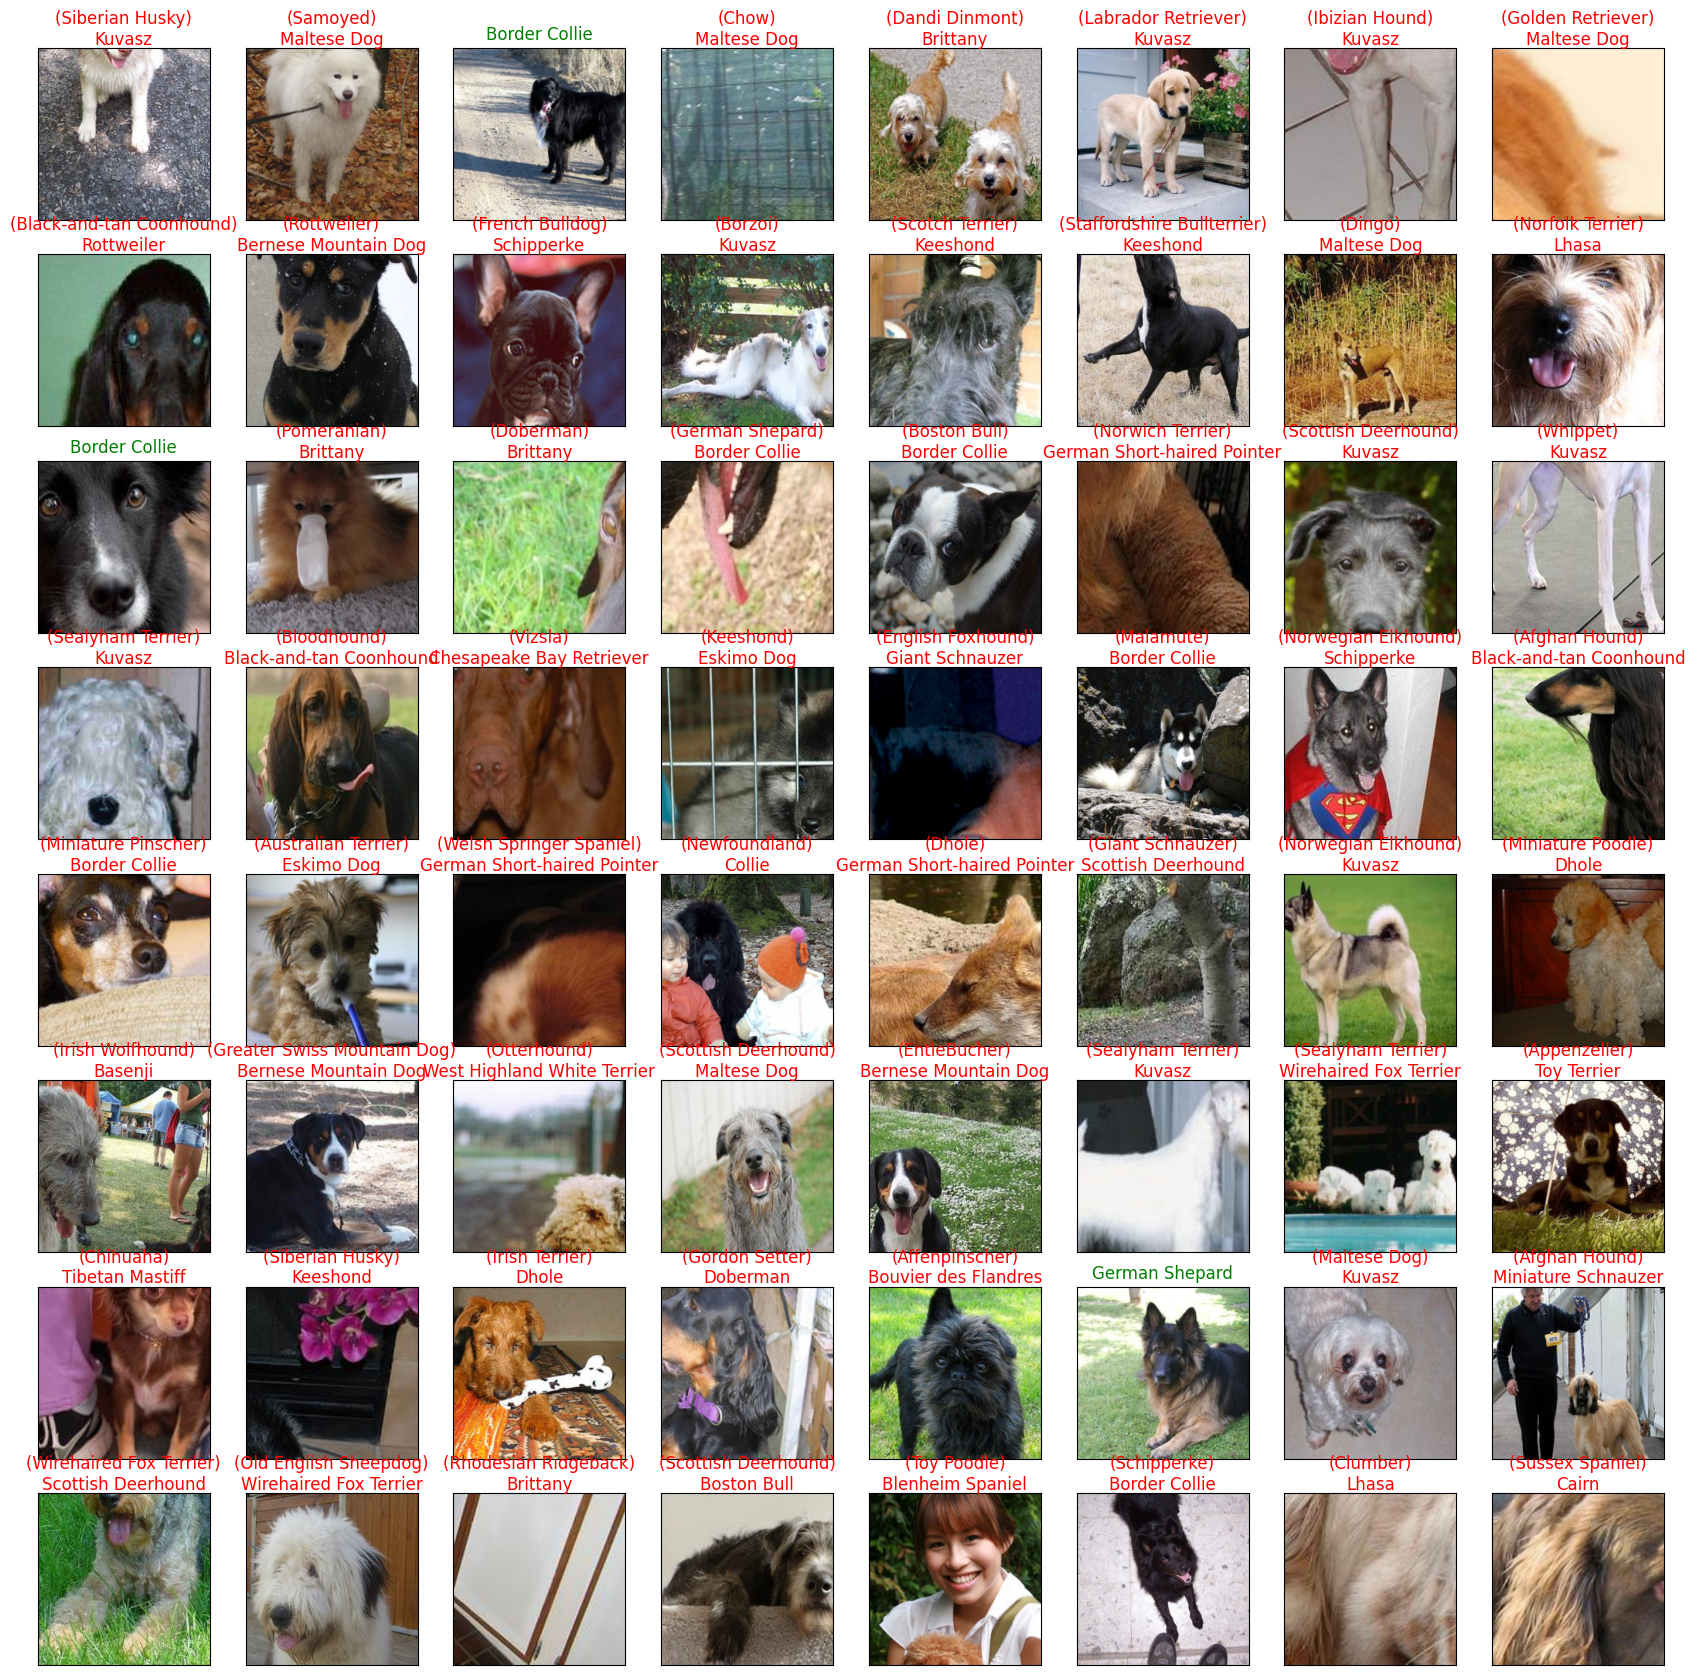

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(batch_size/4+5, batch_size/4+5))
misclassification_found = False
while(not misclassification_found):
    fig.clf()
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    # get predictions
    preds = np.squeeze(model(images).data.max(1, keepdim=True)[1].cpu().numpy())
    images = np.swapaxes(np.swapaxes(images.cpu().numpy(), 1, 2), 2, 3)
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(batch_size//8, 8, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx])
        if preds[idx]==labels[idx]:
            ax.set_title("{}".format(classes[preds[idx]], classes[labels[idx]]), color="green")
        else:
            ax.set_title("({})\n{}".format(classes[labels[idx]], classes[preds[idx]]), color="red", pad=.4)
            misclassification_found = True
# if plot_path:
#     plt.savefig(os.path.join(plot_path, "Results Visualization"))
# else:
plt.show()
plt.clf()
